# Import

In [1]:
import torch
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau, MultiStepLR
from torch.utils.data import DataLoader
from fvcore.nn import FlopCountAnalysis, flop_count_table
import numpy as np
import matplotlib.pyplot as plt
import os

####################################################
from src.Mydataloader import LoadDataset
from src.Mymodel import MyResNet34
from src.Mymodel import MyResNet_CIFAR
from src.Mytraining import DoTraining
from src.Earlystopper import EarlyStopper
from src.LogViewer import LogViewer

# Setup

In [2]:
"""Dataset selection"""
DATASET = "CIFAR10"
# DATASET = "CIFAR100"
# DATASET = "ImageNet2012"

"""Model selection for CIFAR"""
NUM_LAYERS_LEVEL = 5

"""Dataset parameters"""
BATCH = 128
SHUFFLE = True
NUMOFWORKERS = 8
PIN_MEMORY = True
SPLIT_RATIO = 0.9

"""optimizer parameters"""
OPTIMIZER = "SGD"
# OPTIMIZER = "Adam"
# OPTIMIZER = "Adam_decay"

"""Learning rate scheduler parameters"""
# LOAD_BEFORE_TRAINING = False
LOAD_BEFORE_TRAINING = True
NUM_EPOCHS = 500
# scheduler_patience_mapping = {"CIFAR10": 200, "CIFAR100": 200, "ImageNet2012": 30}

"""Early stopping parameters"""
EARLYSTOPPINGPATIENCE = 90
file_path = ""
if DATASET == "ImageNet2012":
    file_path = f"{DATASET}/MyResNet34_{BATCH}_{OPTIMIZER}"
else:
    file_path = f"{DATASET}/MyResNet{NUM_LAYERS_LEVEL*6+2}_{BATCH}_{OPTIMIZER}"

if SPLIT_RATIO != 0:
    file_path += f"_{int(SPLIT_RATIO*100)}"

In [3]:
file_path

'CIFAR10/MyResNet32_128_SGD_90'

# Loading the dataset

## Define Dateloader

In [4]:
tmp = LoadDataset(root="data", seceted_dataset=DATASET, split_ratio=SPLIT_RATIO)
train_data, valid_data, test_data, COUNT_OF_CLASSES = tmp.Unpack()

/home/lee/anaconda3/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


-----------------------------------------------------------------------
Dataset :  CIFAR10
- Length of Train Set :  45000
- Length of Valid Set :  5000
- Length of Test Set :  10000
- Count of Classes :  10
-----------------------------------------------------------------------


In [5]:

train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH,
    shuffle=SHUFFLE,
    num_workers=NUMOFWORKERS,
    pin_memory=PIN_MEMORY,
    # pin_memory_device="cuda",
    persistent_workers=True,
)
print("train.transforms =", train_data.transform, train_dataloader.batch_size)

if valid_data is not None:
    valid_dataloader = DataLoader(
        valid_data,
        batch_size=BATCH,
        shuffle=SHUFFLE,
        num_workers=NUMOFWORKERS,
        pin_memory=PIN_MEMORY,
        # pin_memory_device="cuda",
        persistent_workers=True,
    )
    print("valid.transforms =", valid_data.transform, valid_dataloader.batch_size)
else:
    valid_dataloader = None

if test_data is not None:
    test_dataloader = DataLoader(
        test_data,
        batch_size=BATCH,
        shuffle=SHUFFLE,
        num_workers=NUMOFWORKERS,
        pin_memory=PIN_MEMORY,
        # pin_memory_device="cuda",
        persistent_workers=True,
    )
    print("test.transforms =", test_data.transform, test_dataloader.batch_size)
else:
    test_dataloader = None

train.transforms = Compose(
      AutoAugment(interpolation=InterpolationMode.NEAREST, policy=AutoAugmentPolicy.CIFAR10)
      RandomCrop(size=(32, 32), padding=[4, 4, 4, 4], pad_if_needed=False, fill=0, padding_mode=constant)
      RandomHorizontalFlip(p=0.5)
      ToTensor()
      Normalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[1, 1, 1], inplace=True)
) 128
valid.transforms = ToTensor() 128
test.transforms = ToTensor() 128


## Confirm that the dataset is loaded properly

Shape of X [N, C, H, W]: torch.Size([128, 3, 32, 32])
mean of X tensor([0.5074, 0.4963, 0.4528])
Shape of y: torch.Size([128]) torch.int64


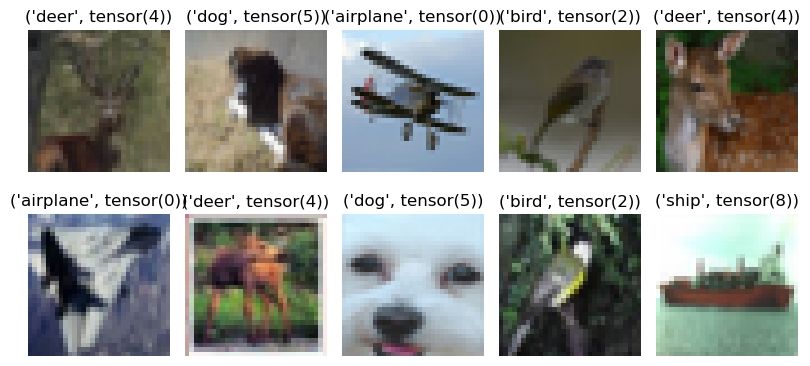

In [6]:
if test_data is not None:
    for X, y in test_dataloader:
        print(f"Shape of X [N, C, H, W]: {X.shape}")
        print("mean of X", X.mean(dim=(0, 2, 3)))
        print(f"Shape of y: {y.shape} {y.dtype}")
        break
    
    class_names = test_dataloader.dataset.classes
    count = 0
    fig, axs = plt.subplots(2, 5, figsize=(8, 4))

    for images, labels in test_dataloader:
        images = images.numpy()

        for i in range(len(images)):
            image = images[i]
            label = labels[i]
            image = np.transpose(image, (1, 2, 0))
            image = np.clip(image, 0, 1)
            ax = axs[count // 5, count % 5]
            ax.imshow(image)
            ax.set_title(f"{class_names[label], label}")
            ax.axis("off")
            count += 1

            if count == 10:
                break
        if count == 10:
            break
    plt.tight_layout()
    plt.show()

# Define ResNet

## Model Confirm

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
if DATASET == "CIFAR10" or DATASET == "CIFAR100":
    """ResNet{20, 32, 44, 56, 110, 1202} for CIFAR"""
    model = MyResNet_CIFAR(
        num_classes=COUNT_OF_CLASSES,
        num_layer_factor=NUM_LAYERS_LEVEL,
        Downsample_option="A",
    ).to(device)
    print(f"ResNet-{5*6+2} for {DATASET} is loaded.")

elif DATASET == "ImageNet2012":
    """ResNet34 for ImageNet 2012"""
    model = MyResNet34(
        num_classes=COUNT_OF_CLASSES, 
        Downsample_option="A"
    ).to(device)
    # model = models.resnet34(pretrained=True).to(device)
    # model = models.resnet34(pretrained=False).to(device)
    print(f"ResNet-34 for {DATASET} is loaded.")


ResNet-32 for CIFAR10 is loaded.


In [9]:
# model.named_modules

In [10]:
# tmp_input = torch.rand(BATCH, 3, 32, 32).to(device)
# flops = FlopCountAnalysis(model, tmp_input)
# print(flop_count_table(flops))

# Define Training

## (1) Define Criterion

In [11]:
criterion = nn.CrossEntropyLoss()

## (2) Define Optimazer

In [12]:
if OPTIMIZER == "Adam":
    optimizer = torch.optim.Adam(model.parameters())
elif OPTIMIZER == "Adam_decay":
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "SGD":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001
    )

## (3) Define Early Stopping

In [13]:
earlystopper = EarlyStopper(patience=EARLYSTOPPINGPATIENCE, model=model, file_path=file_path)

## (4) Define Learning Rate schedualer

In [14]:
# scheduler = ReduceLROnPlateau(
#     optimizer,
#     mode="min",
#     patience=scheduler_patience_mapping[DATASET],
#     factor=0.1,
#     verbose=True,
#     threshold=1e-4,
#     cooldown=100,
# )

scheduler = MultiStepLR(optimizer, milestones=[91, 137], gamma=0.1)
#
"""
=======================================================
if batch = 256
=======================================================
non-split [single epoch = 196 iter] : milestones = [164, 246]
- 1 ~ 164 epochs == 1 ~ 32k iter >> lr = 0.1
- 165~246 epochs == 32k ~ 48k iter >> lr = 0.01
- 247~328(?) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
split to 45k/5k [single epoch = 176 iter]: milestones = [182, 273]
- 1~182 epochs == 1 ~ 32k iter >> lr = 0.1
- 182~273 epochs == 32k ~ 48k iter >> lr = 0.01
- 273~364(?) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
if batch = 128
=======================================================
non-split [signle epoch = 391 iter]: milestones = [82, 123]
- 1 ~ 82 epochs == 1 ~ 32k iter >> lr = 0.1
- 83~123 epochs == 32k ~ 48k iter >> lr = 0.01
- 124~(164) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
split to 45k/5k [signle epoch = 352 iter]: milestones = [91, 137]
- 1~91 epochs == 1 ~ 32k iter >> lr = 0.1
- 92~137 epochs == 32k ~ 48k iter >> lr = 0.01
- 138~(183) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
"""

'\n=======================================================\nif batch = 256\n=======================================================\nnon-split [single epoch = 196 iter] : milestones = [164, 246]\n- 1 ~ 164 epochs == 1 ~ 32k iter >> lr = 0.1\n- 165~246 epochs == 32k ~ 48k iter >> lr = 0.01\n- 247~328(?) epochs == 48k ~ 64k iter >> lr = 0.001\n=======================================================\nsplit to 45k/5k [single epoch = 176 iter]: milestones = [182, 273]\n- 1~182 epochs == 1 ~ 32k iter >> lr = 0.1\n- 182~273 epochs == 32k ~ 48k iter >> lr = 0.01\n- 273~364(?) epochs == 48k ~ 64k iter >> lr = 0.001\n=======================================================\nif batch = 128\n=======================================================\nnon-split [signle epoch = 391 iter]: milestones = [82, 123]\n- 1 ~ 82 epochs == 1 ~ 32k iter >> lr = 0.1\n- 83~123 epochs == 32k ~ 48k iter >> lr = 0.01\n- 124~(164) epochs == 48k ~ 64k iter >> lr = 0.001\n=================================================

## (5) Define AMP scaler

In [15]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

## Load before process

In [16]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

if LOAD_BEFORE_TRAINING == True and os.path.exists("logs/" + file_path + ".pth.tar"):
    # Read checkpoint as desired, e.g.,
    checkpoint = torch.load(
        "logs/" + file_path + ".pth.tar",
        map_location=lambda storage, loc: storage.cuda(device),
    )
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    scaler.load_state_dict(checkpoint["scaler"])
    scheduler.load_state_dict(checkpoint["scheduler"])
    earlystopper.load_state_dict(checkpoint["earlystopper"])
    logs = checkpoint["logs"]

    print("Suceessfully loaded the All setting and Log file.")
    print(file_path)
    print(f"Current epoch is {len(logs['train_loss'])}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")
else:
    # Create a dictionary to store the variables
    train_loss = []
    train_acc = []
    eval_loss = []
    valid_acc = []
    test_loss = []
    test_acc = []
    lr_log = []
    logs = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "valid_loss": eval_loss,
        "valid_acc": valid_acc,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "lr_log": lr_log,
    }
    print("File does not exist. Created a new log.")

Suceessfully loaded the All setting and Log file.
CIFAR10/MyResNet32_128_SGD_90
Current epoch is 229
Current learning rate: 0.0010000000000000002


In [17]:
optimizer.param_groups[0]["lr"]

0.0010000000000000002

In [21]:
earlystopper.early_stop_counter

0

# [Training Loop]

In [19]:
if valid_data is None:
    valid_dataloader = None
if test_data is None:
    test_dataloader = None

In [22]:
Training = DoTraining(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    scheduler=scheduler,
    earlystopper=earlystopper,
    device=device,
    logs=logs,
    file_path=file_path,
)
pre_epochs = len(Training.logs["train_loss"])

for epoch in range(NUM_EPOCHS):
    now = epoch + 1 + pre_epochs
    print(f"[Epoch {epoch+1+pre_epochs}/{NUM_EPOCHS}] :")

    if DATASET == "ImageNet2012":
        eval_loss = Training.SingleEpoch(train_dataloader, valid_dataloader)
    else:
        eval_loss = Training.SingleEpoch(
            train_dataloader, valid_dataloader, test_dataloader
        )

    Training.Save()

    if earlystopper.check(eval_loss) == True:
        break

    print("-" * 50)

[Epoch 231/500] :


100%|██████████| 352/352 [00:14<00:00, 24.09it/s]


Train Loss: 0.0011 | Train Acc: 87.50%
Valid Loss: 0.2501 | Valid Acc: 91.36%
Test  Loss: 0.3089 | Test Acc: 89.94%
updated best eval loss : 0.25008016275241973
--------------------------------------------------
[Epoch 232/500] :


100%|██████████| 352/352 [00:15<00:00, 22.89it/s]


Train Loss: 0.0008 | Train Acc: 90.28%
Valid Loss: 0.2480 | Valid Acc: 91.84%
Test  Loss: 0.3176 | Test Acc: 89.60%
updated best eval loss : 0.2480434525758028
--------------------------------------------------
[Epoch 233/500] :


100%|██████████| 352/352 [00:14<00:00, 23.63it/s]


Train Loss: 0.0013 | Train Acc: 86.11%
Valid Loss: 0.2185 | Valid Acc: 92.24%
Test  Loss: 0.3344 | Test Acc: 89.31%
updated best eval loss : 0.21847929519135506
--------------------------------------------------
[Epoch 234/500] :


100%|██████████| 352/352 [00:14<00:00, 23.52it/s]


Train Loss: 0.0007 | Train Acc: 91.67%
Valid Loss: 0.2281 | Valid Acc: 91.96%
Test  Loss: 0.3273 | Test Acc: 89.55%
--------------------------------------------------
[Epoch 235/500] :


100%|██████████| 352/352 [00:15<00:00, 23.03it/s]


Train Loss: 0.0005 | Train Acc: 94.44%
Valid Loss: 0.2313 | Valid Acc: 92.20%
Test  Loss: 0.3298 | Test Acc: 89.34%
--------------------------------------------------
[Epoch 236/500] :


100%|██████████| 352/352 [00:14<00:00, 23.69it/s]


Train Loss: 0.0014 | Train Acc: 87.50%
Valid Loss: 0.2292 | Valid Acc: 92.10%
Test  Loss: 0.3151 | Test Acc: 89.74%
--------------------------------------------------
[Epoch 237/500] :


100%|██████████| 352/352 [00:15<00:00, 23.15it/s]


Train Loss: 0.0005 | Train Acc: 95.83%
Valid Loss: 0.2406 | Valid Acc: 91.98%
Test  Loss: 0.3281 | Test Acc: 89.42%
--------------------------------------------------
[Epoch 238/500] :


100%|██████████| 352/352 [00:14<00:00, 23.76it/s]


Train Loss: 0.0010 | Train Acc: 87.50%
Valid Loss: 0.2277 | Valid Acc: 92.20%
Test  Loss: 0.3313 | Test Acc: 89.44%
--------------------------------------------------
[Epoch 239/500] :


100%|██████████| 352/352 [00:14<00:00, 23.47it/s]


Train Loss: 0.0004 | Train Acc: 95.83%
Valid Loss: 0.2224 | Valid Acc: 92.36%
Test  Loss: 0.3217 | Test Acc: 89.53%
--------------------------------------------------
[Epoch 240/500] :


100%|██████████| 352/352 [00:15<00:00, 23.31it/s]


Train Loss: 0.0007 | Train Acc: 88.89%
Valid Loss: 0.2289 | Valid Acc: 91.90%
Test  Loss: 0.3254 | Test Acc: 89.53%
--------------------------------------------------
[Epoch 241/500] :


100%|██████████| 352/352 [00:14<00:00, 23.76it/s]


Train Loss: 0.0006 | Train Acc: 93.06%
Valid Loss: 0.2223 | Valid Acc: 91.80%
Test  Loss: 0.3268 | Test Acc: 89.59%
--------------------------------------------------
[Epoch 242/500] :


100%|██████████| 352/352 [00:15<00:00, 23.33it/s]


Train Loss: 0.0006 | Train Acc: 94.44%
Valid Loss: 0.2257 | Valid Acc: 92.28%
Test  Loss: 0.3166 | Test Acc: 89.78%
--------------------------------------------------
[Epoch 243/500] :


100%|██████████| 352/352 [00:15<00:00, 23.28it/s]


Train Loss: 0.0003 | Train Acc: 98.61%
Valid Loss: 0.2308 | Valid Acc: 92.00%
Test  Loss: 0.3169 | Test Acc: 89.76%
--------------------------------------------------
[Epoch 244/500] :


100%|██████████| 352/352 [00:15<00:00, 23.19it/s]


Train Loss: 0.0006 | Train Acc: 93.06%
Valid Loss: 0.2219 | Valid Acc: 92.20%
Test  Loss: 0.3269 | Test Acc: 89.57%
--------------------------------------------------
[Epoch 245/500] :


100%|██████████| 352/352 [00:15<00:00, 22.90it/s]


Train Loss: 0.0010 | Train Acc: 86.11%
Valid Loss: 0.2362 | Valid Acc: 91.68%
Test  Loss: 0.3265 | Test Acc: 89.40%
--------------------------------------------------
[Epoch 246/500] :


100%|██████████| 352/352 [00:14<00:00, 23.59it/s]


Train Loss: 0.0006 | Train Acc: 93.06%
Valid Loss: 0.2383 | Valid Acc: 91.88%
Test  Loss: 0.3269 | Test Acc: 89.57%
--------------------------------------------------
[Epoch 247/500] :


100%|██████████| 352/352 [00:15<00:00, 23.39it/s]


Train Loss: 0.0005 | Train Acc: 94.44%
Valid Loss: 0.2236 | Valid Acc: 92.36%
Test  Loss: 0.3111 | Test Acc: 89.94%
--------------------------------------------------
[Epoch 248/500] :


100%|██████████| 352/352 [00:15<00:00, 23.20it/s]


Train Loss: 0.0006 | Train Acc: 94.44%
Valid Loss: 0.2323 | Valid Acc: 92.08%
Test  Loss: 0.3131 | Test Acc: 89.90%
--------------------------------------------------
[Epoch 249/500] :


100%|██████████| 352/352 [00:15<00:00, 23.22it/s]


Train Loss: 0.0004 | Train Acc: 93.06%
Valid Loss: 0.2261 | Valid Acc: 92.02%
Test  Loss: 0.3252 | Test Acc: 89.68%
--------------------------------------------------
[Epoch 250/500] :


100%|██████████| 352/352 [00:14<00:00, 23.92it/s]


Train Loss: 0.0005 | Train Acc: 94.44%
Valid Loss: 0.2216 | Valid Acc: 92.42%
Test  Loss: 0.3211 | Test Acc: 89.70%
--------------------------------------------------
[Epoch 251/500] :


100%|██████████| 352/352 [00:15<00:00, 23.44it/s]


Train Loss: 0.0006 | Train Acc: 93.06%
Valid Loss: 0.2302 | Valid Acc: 92.22%
Test  Loss: 0.3224 | Test Acc: 89.50%
--------------------------------------------------
[Epoch 252/500] :


100%|██████████| 352/352 [00:14<00:00, 23.48it/s]


Train Loss: 0.0010 | Train Acc: 88.89%
Valid Loss: 0.2183 | Valid Acc: 92.42%
Test  Loss: 0.3198 | Test Acc: 89.72%
updated best eval loss : 0.2182884018868208
--------------------------------------------------
[Epoch 253/500] :


100%|██████████| 352/352 [00:14<00:00, 23.71it/s]


Train Loss: 0.0011 | Train Acc: 88.89%
Valid Loss: 0.2311 | Valid Acc: 92.56%
Test  Loss: 0.3308 | Test Acc: 89.43%
--------------------------------------------------
[Epoch 254/500] :


100%|██████████| 352/352 [00:14<00:00, 23.66it/s]


Train Loss: 0.0010 | Train Acc: 91.67%
Valid Loss: 0.2099 | Valid Acc: 92.62%
Test  Loss: 0.3197 | Test Acc: 89.58%
updated best eval loss : 0.20986897703260182
--------------------------------------------------
[Epoch 255/500] :


100%|██████████| 352/352 [00:15<00:00, 23.33it/s]


Train Loss: 0.0005 | Train Acc: 95.83%
Valid Loss: 0.2147 | Valid Acc: 92.24%
Test  Loss: 0.3208 | Test Acc: 89.56%
--------------------------------------------------
[Epoch 256/500] :


100%|██████████| 352/352 [00:15<00:00, 23.12it/s]


Train Loss: 0.0005 | Train Acc: 94.44%
Valid Loss: 0.2064 | Valid Acc: 92.60%
Test  Loss: 0.3189 | Test Acc: 89.75%
updated best eval loss : 0.20644362678285688
--------------------------------------------------
[Epoch 257/500] :


100%|██████████| 352/352 [00:15<00:00, 23.44it/s]


Train Loss: 0.0008 | Train Acc: 86.11%
Valid Loss: 0.2287 | Valid Acc: 92.06%
Test  Loss: 0.3295 | Test Acc: 89.55%
--------------------------------------------------
[Epoch 258/500] :


100%|██████████| 352/352 [00:14<00:00, 23.57it/s]


Train Loss: 0.0004 | Train Acc: 95.83%
Valid Loss: 0.2283 | Valid Acc: 92.18%
Test  Loss: 0.3259 | Test Acc: 89.72%
--------------------------------------------------
[Epoch 259/500] :


100%|██████████| 352/352 [00:14<00:00, 24.05it/s]


Train Loss: 0.0007 | Train Acc: 90.28%
Valid Loss: 0.2302 | Valid Acc: 92.18%
Test  Loss: 0.3253 | Test Acc: 89.66%
--------------------------------------------------
[Epoch 260/500] :


100%|██████████| 352/352 [00:14<00:00, 23.61it/s]


Train Loss: 0.0009 | Train Acc: 86.11%
Valid Loss: 0.2100 | Valid Acc: 92.72%
Test  Loss: 0.3152 | Test Acc: 89.75%
--------------------------------------------------
[Epoch 261/500] :


100%|██████████| 352/352 [00:15<00:00, 23.25it/s]


Train Loss: 0.0006 | Train Acc: 95.83%
Valid Loss: 0.2424 | Valid Acc: 91.34%
Test  Loss: 0.3181 | Test Acc: 89.77%
--------------------------------------------------
[Epoch 262/500] :


100%|██████████| 352/352 [00:14<00:00, 23.70it/s]


Train Loss: 0.0007 | Train Acc: 93.06%
Valid Loss: 0.2246 | Valid Acc: 92.04%
Test  Loss: 0.3139 | Test Acc: 89.96%
--------------------------------------------------
[Epoch 263/500] :


100%|██████████| 352/352 [00:15<00:00, 23.21it/s]


Train Loss: 0.0005 | Train Acc: 97.22%
Valid Loss: 0.2193 | Valid Acc: 92.50%
Test  Loss: 0.3221 | Test Acc: 89.57%
--------------------------------------------------
[Epoch 264/500] :


100%|██████████| 352/352 [00:14<00:00, 23.93it/s]


Train Loss: 0.0010 | Train Acc: 88.89%
Valid Loss: 0.2181 | Valid Acc: 92.48%
Test  Loss: 0.3357 | Test Acc: 89.34%
--------------------------------------------------
[Epoch 265/500] :


100%|██████████| 352/352 [00:14<00:00, 23.77it/s]


Train Loss: 0.0006 | Train Acc: 93.06%
Valid Loss: 0.2218 | Valid Acc: 92.40%
Test  Loss: 0.3275 | Test Acc: 89.51%
--------------------------------------------------
[Epoch 266/500] :


100%|██████████| 352/352 [00:14<00:00, 23.71it/s]


Train Loss: 0.0006 | Train Acc: 95.83%
Valid Loss: 0.2340 | Valid Acc: 92.00%
Test  Loss: 0.3280 | Test Acc: 89.54%
--------------------------------------------------
[Epoch 267/500] :


100%|██████████| 352/352 [00:14<00:00, 23.47it/s]


Train Loss: 0.0010 | Train Acc: 86.11%
Valid Loss: 0.2353 | Valid Acc: 92.18%
Test  Loss: 0.3328 | Test Acc: 89.43%
--------------------------------------------------
[Epoch 268/500] :


100%|██████████| 352/352 [00:15<00:00, 23.45it/s]


Train Loss: 0.0008 | Train Acc: 88.89%
Valid Loss: 0.2271 | Valid Acc: 92.36%
Test  Loss: 0.3290 | Test Acc: 89.38%
--------------------------------------------------
[Epoch 269/500] :


100%|██████████| 352/352 [00:15<00:00, 23.21it/s]


Train Loss: 0.0006 | Train Acc: 95.83%
Valid Loss: 0.2015 | Valid Acc: 93.06%
Test  Loss: 0.3244 | Test Acc: 89.70%
updated best eval loss : 0.2015449077123776
--------------------------------------------------
[Epoch 270/500] :


100%|██████████| 352/352 [00:15<00:00, 22.37it/s]


Train Loss: 0.0006 | Train Acc: 91.67%
Valid Loss: 0.2293 | Valid Acc: 92.60%
Test  Loss: 0.3284 | Test Acc: 89.65%
--------------------------------------------------
[Epoch 271/500] :


100%|██████████| 352/352 [00:26<00:00, 13.06it/s]


Train Loss: 0.0004 | Train Acc: 95.83%
Valid Loss: 0.2222 | Valid Acc: 92.38%
Test  Loss: 0.3372 | Test Acc: 89.14%
--------------------------------------------------
[Epoch 272/500] :


100%|██████████| 352/352 [00:26<00:00, 13.06it/s]


Train Loss: 0.0009 | Train Acc: 86.11%
Valid Loss: 0.2287 | Valid Acc: 92.42%
Test  Loss: 0.3356 | Test Acc: 89.19%
--------------------------------------------------
[Epoch 273/500] :


100%|██████████| 352/352 [00:27<00:00, 12.86it/s]


Train Loss: 0.0010 | Train Acc: 86.11%
Valid Loss: 0.2110 | Valid Acc: 92.54%
Test  Loss: 0.3279 | Test Acc: 89.64%
--------------------------------------------------
[Epoch 274/500] :


100%|██████████| 352/352 [00:27<00:00, 12.78it/s]


Train Loss: 0.0006 | Train Acc: 94.44%
Valid Loss: 0.2166 | Valid Acc: 92.50%
Test  Loss: 0.3244 | Test Acc: 89.54%
--------------------------------------------------
[Epoch 275/500] :


  8%|▊         | 29/352 [00:02<00:27, 11.84it/s]


KeyboardInterrupt: 

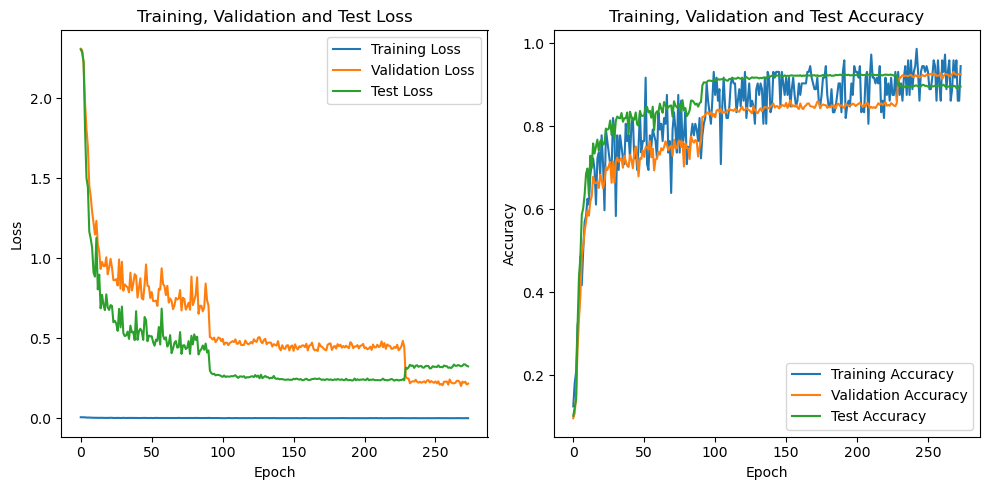

In [23]:
view = LogViewer(logs)
view.draw()

In [24]:
view.print_all()

1 epoch: train_loss=0.0065, train_acc=0.1250, test_loss=2.3040, test_acc=0.1023, valid_loss=2.3080, valid_acc=0.0964, lr=0.1000
2 epoch: train_loss=0.0064, train_acc=0.1806, test_loss=2.2848, test_acc=0.1216, valid_loss=2.2993, valid_acc=0.1086, lr=0.1000
3 epoch: train_loss=0.0063, train_acc=0.2083, test_loss=2.2252, test_acc=0.1417, valid_loss=2.2177, valid_acc=0.1488, lr=0.1000
4 epoch: train_loss=0.0058, train_acc=0.3194, test_loss=1.8125, test_acc=0.3150, valid_loss=1.9710, valid_acc=0.2622, lr=0.1000
5 epoch: train_loss=0.0051, train_acc=0.3472, test_loss=1.5028, test_acc=0.4366, valid_loss=1.8106, valid_acc=0.3332, lr=0.1000
6 epoch: train_loss=0.0043, train_acc=0.4861, test_loss=1.4453, test_acc=0.4837, valid_loss=1.6970, valid_acc=0.3930, lr=0.1000
7 epoch: train_loss=0.0047, train_acc=0.4167, test_loss=1.1659, test_acc=0.5863, valid_loss=1.4518, valid_acc=0.4878, lr=0.1000
8 epoch: train_loss=0.0038, train_acc=0.5000, test_loss=1.1229, test_acc=0.6024, valid_loss=1.3869, vali

In [ ]:
# CHECK = 5410
# logs["train_loss"] = logs["train_loss"][:CHECK]
# logs["train_acc"] = logs["train_acc"][:CHECK]
# logs["valid_loss"] = logs["valid_loss"][:CHECK]
# logs["valid_acc"] = logs["valid_acc"][:CHECK]
# logs["test_loss"] = logs["test_loss"][:CHECK]
# logs["test_acc"] = logs["test_acc"][:CHECK]
# model.load_state_dict(torch.load(f"models/{file_path}.pth"))